## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [4]:
series_codes = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

base = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
url_bcrp = f"{base}/{'-'.join(series_codes)}/json"

print(url_bcrp)



https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [5]:
import requests
import pandas as pd
import re

In [6]:
# 2) Descargar JSON
resp = requests.get(url_bcrp, timeout=30)
resp.raise_for_status()
data = resp.json()

# 3) Parser robusto para fechas del BCRP (incluye formato español: 29.Dic.25)
MONTHS_ES = {
    "Ene": 1, "Feb": 2, "Mar": 3, "Abr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Ago": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dic": 12
}

def parse_bcrp_date(x) -> pd.Timestamp:
    s = str(x).strip()

    # Formato español: 29.Dic.25
    m = re.match(r"^(\d{1,2})\.([A-Za-zÁÉÍÓÚáéíóúÑñ]{3})\.(\d{2})$", s)
    if m:
        d = int(m.group(1))
        mon_txt = m.group(2).capitalize()
        yy = int(m.group(3))

        month = MONTHS_ES.get(mon_txt)
        if month is None:
            return pd.NaT

        # Regla estándar para 2 dígitos: 00-69 => 2000-2069, 70-99 => 1970-1999
        year = 2000 + yy if yy <= 69 else 1900 + yy
        return pd.Timestamp(year, month, d)

    # ISO u otros parseables (incluye posibles horas)
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return dt

# 4) Tomar códigos desde config si existen (por seguridad con el orden); fallback a series_codes
try:
    codes_from_config = [s["code"] for s in data.get("config", {}).get("series", [])]
except Exception:
    codes_from_config = None

codes = codes_from_config if codes_from_config else series_codes

# 5) Construir tidy (date, series, value)
rows = []
for p in data["periods"]:
    date_raw = p.get("name")
    vals = p.get("values", [])
    for code, val in zip(codes, vals):
        rows.append({
            "date": parse_bcrp_date(date_raw),
            "series": str(code).strip(),
            "value": pd.to_numeric(val, errors="coerce")
        })

tidy = (pd.DataFrame(rows)
          .sort_values(["series", "date"], ignore_index=True))

# 6) Chequeos
#print("Ejemplo fechas crudas:", [pp.get("name") for pp in data["periods"][:5]])
#print("NaT en date:", int(tidy["date"].isna().sum()), "de", len(tidy))
print("Series únicas:", tidy["series"].unique())

tidy.head(15)

Series únicas: ['PD04637PD' 'PD04639PD' 'PD04701XD' 'PD04704XD']


,date,series,value
0,2025-12-29,PD04637PD,3.365286
1,2025-12-30,PD04637PD,3.362571
2,2025-12-31,PD04637PD,3.359200
3,2026-01-01,PD04637PD,NaN
4,2026-01-02,PD04637PD,NaN
5,2026-01-05,PD04637PD,3.362571
6,2026-01-06,PD04637PD,3.359143
7,2026-01-07,PD04637PD,3.361429
8,2026-01-08,PD04637PD,3.362286
9,2025-12-29,PD04639PD,3.361000


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [7]:
# =========================
# PUNTO 3: Clean -> WIDE con columnas: fx_interbank, fx_sbs, gold, copper
# (usa el tidy ya corregido del punto 2)
# =========================

import pandas as pd

# Partimos del tidy del punto 2
bcrp_tidy = tidy.copy()

# Normaliza series (por si acaso hay espacios)
bcrp_tidy["series"] = bcrp_tidy["series"].astype(str).str.strip()

# Mapeo código -> nombre de columna final
series_map = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper",
}

# Filtra solo las 4 series necesarias (evita NaNs por mapeo)
bcrp_4 = bcrp_tidy[bcrp_tidy["series"].isin(series_map.keys())].copy()

# Asegura datetime
bcrp_4["date"] = pd.to_datetime(bcrp_4["date"], errors="coerce")

# Renombra series y pivotea
bcrp_wide = (
    bcrp_4.assign(series=bcrp_4["series"].map(series_map))
          .pivot_table(index="date", columns="series", values="value", aggfunc="first")
          .reset_index()
          .sort_values("date", ignore_index=True)
)

# Fuerza columnas aunque alguna no exista por datos faltantes
wanted = ["fx_interbank", "fx_sbs", "gold", "copper"]
for c in wanted:
    if c not in bcrp_wide.columns:
        bcrp_wide[c] = pd.NA

# Orden final exacto
bcrp_wide = bcrp_wide[["date"] + wanted]

# (Opcional) ver cuántos NaN hay por columna
print("Filas:", len(bcrp_wide))
print("NaN por columna:\n", bcrp_wide[wanted].isna().sum())

bcrp_wide.head(10)



Filas: 9
NaN por columna:
 series
fx_interbank    2
fx_sbs          2
gold            0
copper          0
dtype: int64


series,date,fx_interbank,fx_sbs,gold,copper
0,2025-12-29,3.365286,3.361,558.190776,4332.35
1,2025-12-30,3.362571,3.360,567.534779,4339.49
2,2025-12-31,3.359200,3.358,567.534779,4339.49
3,2026-01-01,NaN,NaN,567.534779,4339.49
4,2026-01-02,NaN,NaN,570.210974,4332.29
5,2026-01-05,3.362571,3.356,584.408415,4449.15
6,2026-01-06,3.359143,3.357,601.894401,4494.83
7,2026-01-07,3.361429,3.359,596.247176,4456.47
8,2026-01-08,3.362286,3.359,584.453775,4477.65


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [8]:
# =========================
# PUNTO 4: Descargar SPY, TLT, GLD (yfinance) y armar tidy: date, ticker, close
# =========================

import pandas as pd
import yfinance as yf

tickers = ["SPY", "TLT", "GLD"]

# (Opcional) pon un rango si tu notebook lo usa; si no, lo puedes borrar
start = "2015-01-01"
end   = None  # o "2026-01-01"

# Descarga (por defecto trae OHLCV)
px = yf.download(
    tickers=tickers,
    start=start,
    end=end,
    auto_adjust=False,
    progress=False,
    group_by="column"
)

# Tomamos el precio de cierre (Close)
close_wide = px["Close"].copy()   # index = Date, columns = tickers

# Wide -> tidy: date, ticker, close
yf_tidy = (
    close_wide.reset_index()
              .melt(id_vars="Date", var_name="ticker", value_name="close")
              .rename(columns={"Date": "date"})
              .sort_values(["ticker", "date"], ignore_index=True)
)

# Asegura datetime y elimina filas sin close (si hay)
yf_tidy["date"] = pd.to_datetime(yf_tidy["date"])
yf_tidy = yf_tidy.dropna(subset=["close"]).reset_index(drop=True)

print("Filas:", len(yf_tidy))
print("Tickers:", yf_tidy["ticker"].unique())
yf_tidy.head(15)


Filas: 8319
Tickers: ['GLD' 'SPY' 'TLT']


,date,ticker,close
0,2015-01-02,GLD,114.080002
1,2015-01-05,GLD,115.800003
2,2015-01-06,GLD,117.120003
3,2015-01-07,GLD,116.430000
4,2015-01-08,GLD,115.940002
5,2015-01-09,GLD,117.260002
6,2015-01-12,GLD,118.559998
7,2015-01-13,GLD,118.160004
8,2015-01-14,GLD,117.970001
9,2015-01-15,GLD,120.940002


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [9]:
import numpy as np
import pandas as pd

# Partimos del df del punto 4
df = yf_tidy.copy()

# 1) Asegurar orden correcto (importantísimo para pct_change)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"], ignore_index=True)

# 2) Retorno diario por ticker
# ret_t = (P_t / P_{t-1}) - 1
df["ret"] = df.groupby("ticker")["close"].pct_change()

# 3) Validación: no inf / -inf
has_inf = np.isinf(df["ret"]).any()
n_inf = np.isinf(df["ret"]).sum()

print("¿Hay inf en ret?:", has_inf)
print("Cantidad de inf:", int(n_inf))

# 4) Si existieran, los convertimos a NaN (por seguridad)
df.loc[np.isinf(df["ret"]), "ret"] = np.nan

# 5) (Opcional pero recomendado) quitar NaNs de ret:
# - el primer día de cada ticker siempre será NaN porque no hay día previo
df_returns = df.dropna(subset=["ret"]).reset_index(drop=True)

df_returns.head(15)


¿Hay inf en ret?: False
Cantidad de inf: 0


,date,ticker,close,ret
0,2015-01-05,GLD,115.800003,0.015077
1,2015-01-06,GLD,117.120003,0.011399
2,2015-01-07,GLD,116.430000,-0.005891
3,2015-01-08,GLD,115.940002,-0.004209
4,2015-01-09,GLD,117.260002,0.011385
5,2015-01-12,GLD,118.559998,0.011086
6,2015-01-13,GLD,118.160004,-0.003374
7,2015-01-14,GLD,117.970001,-0.001608
8,2015-01-15,GLD,120.940002,0.025176
9,2015-01-16,GLD,122.519997,0.013064


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


In [10]:
import pandas as pd

# Ver qué tickers tienes
print("Tickers en df_returns:", df_returns["ticker"].unique())

# Ajusta si tu ticker FX no coincide:
# (Elige el que NO sea "SPY")
fx_candidates = [t for t in df_returns["ticker"].unique() if t != "SPY"]
fx_ticker = fx_candidates[0]  # usa el primero encontrado
print("FX ticker elegido:", fx_ticker)

# Series por fecha (solo columnas necesarias)
fx = (df_returns[df_returns["ticker"] == fx_ticker][["date", "ret"]]
      .rename(columns={"ret": "FX_change"}))

spy = (df_returns[df_returns["ticker"] == "SPY"][["date", "ret"]]
       .rename(columns={"ret": "SPY_ret"}))

# Alinear por fecha (solo fechas que existen en ambos)
pair = (pd.merge(fx, spy, on="date", how="inner")
        .dropna()
        .sort_values("date"))

pair.head()

Tickers en df_returns: ['GLD' 'SPY' 'TLT']
FX ticker elegido: GLD


,date,FX_change,SPY_ret
0,2015-01-05,0.015077,-0.018060
1,2015-01-06,0.011399,-0.009419
2,2015-01-07,-0.005891,0.012461
3,2015-01-08,-0.004209,0.017745
4,2015-01-09,0.011385,-0.008014


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [11]:
corr = pair["FX_change"].corr(pair["SPY_ret"])
print("Correlación (FX_change vs SPY_ret):", corr)

# Interpretación simple
if abs(corr) < 0.1:
    print("Interpretación: relación lineal muy débil (casi nula).")
elif abs(corr) < 0.3:
    print("Interpretación: relación débil.")
elif abs(corr) < 0.6:
    print("Interpretación: relación moderada.")
else:
    print("Interpretación: relación fuerte.")


Correlación (FX_change vs SPY_ret): 0.04359951413731946
Interpretación: relación lineal muy débil (casi nula).


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


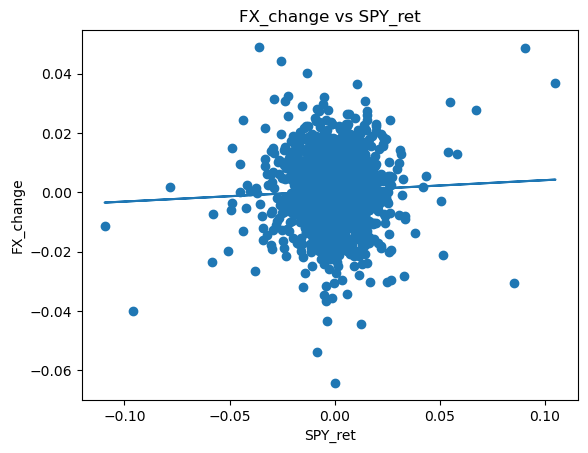

Recta tendencia: FX_change ≈ 0.0361 * SPY_ret + 0.0005


In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = pair["SPY_ret"].values
y = pair["FX_change"].values

m, b = np.polyfit(x, y, 1)  # y = m*x + b

plt.figure()
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.title("FX_change vs SPY_ret")
plt.xlabel("SPY_ret")
plt.ylabel("FX_change")
plt.show()

print(f"Recta tendencia: FX_change ≈ {m:.4f} * SPY_ret + {b:.4f}")


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [13]:
try:
    import statsmodels.api as sm

    X = sm.add_constant(pair["SPY_ret"])  # agrega intercepto
    y = pair["FX_change"]

    model = sm.OLS(y, X).fit()
    print(model.summary())

except ModuleNotFoundError:
    print("No está instalado statsmodels. Si no te lo piden, puedes quedarte con la correlación y la recta polyfit.")


                            OLS Regression Results                            
Dep. Variable:              FX_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.276
Date:                Mon, 12 Jan 2026   Prob (F-statistic):             0.0217
Time:                        10:05:04   Log-Likelihood:                 9034.5
No. Observations:                2772   AIC:                        -1.807e+04
Df Residuals:                    2770   BIC:                        -1.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.822      0.0

15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


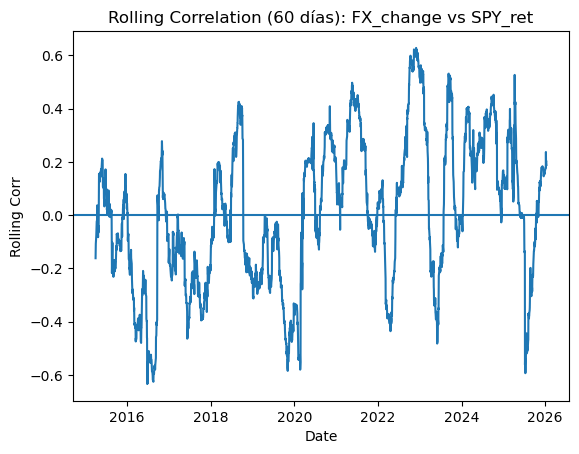

,date,rolling_corr
2767,2026-01-06,0.178341
2768,2026-01-07,0.237367
2769,2026-01-08,0.199055
2770,2026-01-09,0.204796
2771,2026-01-12,0.188731


In [14]:
import matplotlib.pyplot as plt

rolling_window = 60  # 60 días aprox.
pair["rolling_corr"] = pair["FX_change"].rolling(rolling_window).corr(pair["SPY_ret"])

plt.figure()
plt.plot(pair["date"], pair["rolling_corr"])
plt.axhline(0)
plt.title(f"Rolling Correlation ({rolling_window} días): FX_change vs SPY_ret")
plt.xlabel("Date")
plt.ylabel("Rolling Corr")
plt.show()

pair[["date", "rolling_corr"]].tail()


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
